## ☁️ Connect G-Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
%cd /gdrive/My Drive/Homework 2 AN2DL condivisa/PSPNet

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1SjZ_-XjkG_FsuR9orhSxIGp-dNxNdzS1/Homework 2 AN2DL condivisa/PSPNet


## ⚒️ Import libraries


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers, Model

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set_style('white')

%matplotlib inline

2.17.1


In [3]:
# Load the dataset
data = np.load("../Datasets/Dataset_cleaned.npz")
X_train = data["training_set"][0, :]
y_train = data["training_set"][1, :]
X_test = data["test_set"]

In [4]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 15

# Set maximum number of training epochs
EPOCHS = 300

# Number of classes
NUM_CLASSES = 5

## 📈 Parameters & Network

In [5]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=0.1, random_state=seed
)

print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

del train_val_img, train_val_lbl, X_train, y_train

Splitting data...
Data splitted!

Number of images:
Train: 2028
Validation: 226
Test: 251


In [6]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (16, 64, 128)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'float64'>


In [8]:
def PSPNet(input_shape=(64, 128, 1), num_classes=5):

    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Encoder
    down1 = layers.Conv2D(64, (3, 3), padding="same")(inputs)
    down1 = layers.BatchNormalization()(down1)
    down1 = layers.Activation('relu')(down1)

    down1 = layers.Conv2D(64, (3, 3), padding="same")(down1)
    down1 = layers.BatchNormalization()(down1)
    down1_skip = layers.Activation('relu')(down1)

    down2 = layers.MaxPooling2D((2, 2))(down1_skip)

    down2 = layers.Conv2D(128, (3, 3), padding="same")(down2)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.Activation('relu')(down2)

    down2 = layers.Conv2D(128, (3, 3), padding="same")(down2)
    down2 = layers.BatchNormalization()(down2)
    down2_skip = layers.Activation('relu')(down2)

    down3 = layers.MaxPooling2D((2, 2))(down2_skip)

    down3 = layers.Conv2D(256, (3, 3), padding="same")(down3)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.Activation('relu')(down3)

    down3 = layers.Conv2D(256, (3, 3), padding="same")(down3)
    down3 = layers.BatchNormalization()(down3)
    down3_skip = layers.Activation('relu')(down3)

    down4 = layers.MaxPooling2D((2, 2))(down3_skip)

    # Bottleneck
    pool_sizes=[1, 2, 4, 8]
    pooled_outputs = []

    for pool_size in pool_sizes:

        # Apply pooling
        pooled = layers.AveragePooling2D(pool_size)(down4)

        # 1x1 convolution to reduce dimensions
        pooled = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(pooled)

        # 3x3 convolution
        pooled = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(pooled)

        # Calculate the target size for upsampling
        pooled = layers.UpSampling2D(size=(down4.shape[1] // pooled.shape[1], down4.shape[2] // pooled.shape[2]))(pooled)

        # Append to list
        pooled_outputs.append(pooled)

    # Additive fusion
    PSP_output = layers.Add()([down4] + pooled_outputs)

    # Decoder
    up3 = layers.UpSampling2D((2, 2), interpolation='bilinear')(PSP_output)
    up3 = layers.Concatenate()([up3, down3_skip])

    up3 = layers.Conv2D(256, (3, 3), padding="same")(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.Activation('relu')(up3)

    up3 = layers.Conv2D(256, (3, 3), padding="same")(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.Activation('relu')(up3)

    up2 = layers.UpSampling2D((2, 2), interpolation='bilinear')(up3)
    up2 = layers.Concatenate()([up2, down2_skip])

    up2 = layers.Conv2D(128, (3, 3), padding="same")(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.Activation('relu')(up2)

    up2 = layers.Conv2D(128, (3, 3), padding="same")(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.Activation('relu')(up2)

    up1 = layers.UpSampling2D((2, 2), interpolation='bilinear')(up2)
    up1 = layers.Concatenate()([up1, down1_skip])

    up1 = layers.Conv2D(64, (3, 3), padding="same")(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.Activation('relu')(up1)

    up1 = layers.Conv2D(64, (3, 3), padding="same")(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.Activation('relu')(up1)

    # Output layer for multi-class
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(up1)

    return Model(inputs, outputs)

In [9]:
weights = [0, 0.25, 0.25, 0.25, 0.25]

def SparseCategoricalCrossentropyWithWeights(weights):
    """
    Custom Sparse Categorical Crossentropy with class weights.
    Args:
        weights: List or array of class weights, length = numClasses.
    """
    def loss_fn(y_true, y_pred):
        # Convert y_true to int32 for compatibility
        y_true = tf.cast(y_true, tf.int32)

        # Calculate the standard sparse categorical crossentropy loss
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Apply class weights
        class_weights = tf.gather(weights, y_true)  # Select weights based on y_true values
        weighted_loss = scce * class_weights

        # Return mean loss
        return tf.reduce_mean(weighted_loss)

    return loss_fn

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 128, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 128, 64)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 128, 64)    │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 128, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 6,282,885 (23.97 MB)

 Trainable params: 6,279,301 (23.95 MB)

 Non-trainable params: 3,584 (14.00 KB)

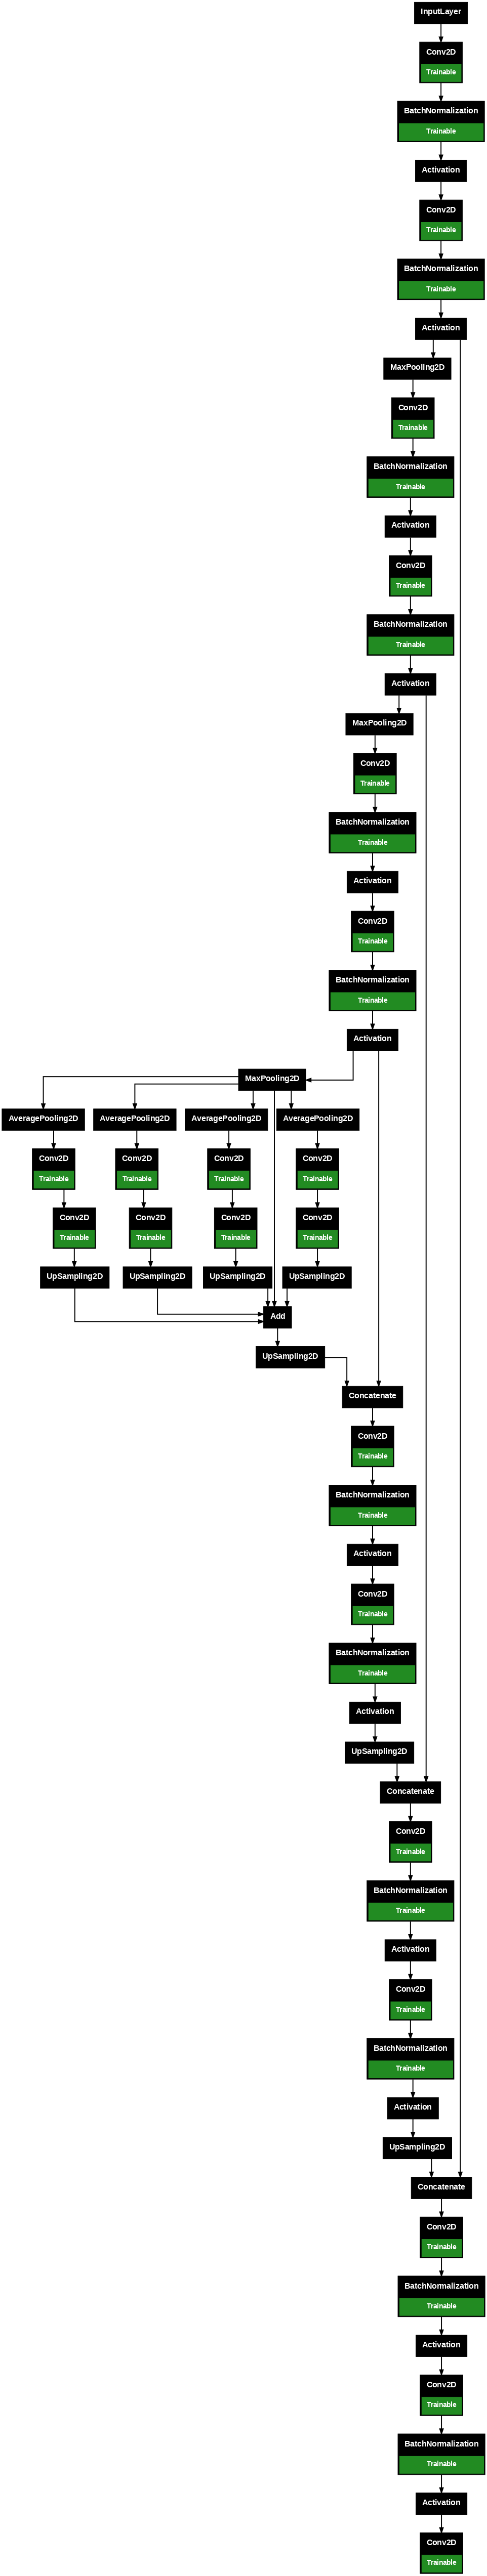

In [10]:
# Mean IntersectionOverUnion as metric
mean_iou = tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class = 0, sparse_y_pred = False)

# Compile the Model
model = PSPNet(input_shape = (64, 128, 1), num_classes = NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss=SparseCategoricalCrossentropyWithWeights(weights),
    metrics=['accuracy', mean_iou]
)

model.summary()

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [11]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_io_u',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_io_u',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

In [12]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
).history

Epoch 1/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 86s 365ms/step - accuracy: 0.4331 - loss: 0.2403 - mean_io_u: 0.2376 - val_accuracy: 0.4978 - val_loss: 0.2110 - val_mean_io_u: 0.2475 - learning_rate: 1.0000e-04
Epoch 2/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.5532 - loss: 0.1501 - mean_io_u: 0.3514 - val_accuracy: 0.5368 - val_loss: 0.1625 - val_mean_io_u: 0.3110 - learning_rate: 1.0000e-04
Epoch 3/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.5645 - loss: 0.1301 - mean_io_u: 0.3628 - val_accuracy: 0.5300 - val_loss: 0.2177 - val_mean_io_u: 0.3110 - learning_rate: 1.0000e-04
Epoch 4/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5970 - loss: 0.1133 - mean_io_u: 0.4027
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.5970 - loss: 0.1132 - mean_io_u: 0.4026 - val_accuracy: 0.5408 - val_loss: 0.2576 - val_mean_io_u: 0.3278 - learning_rate: 1.0000e-04
Epoch 5/300

In [14]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'PSPNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 72.71%


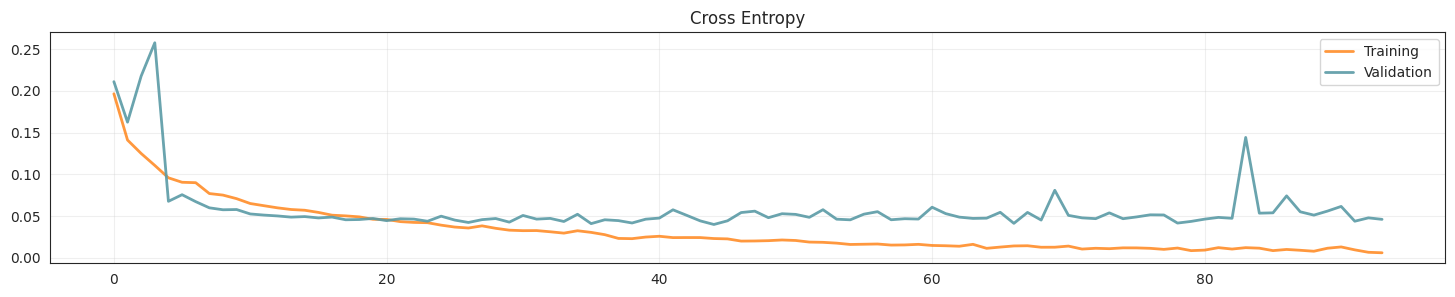

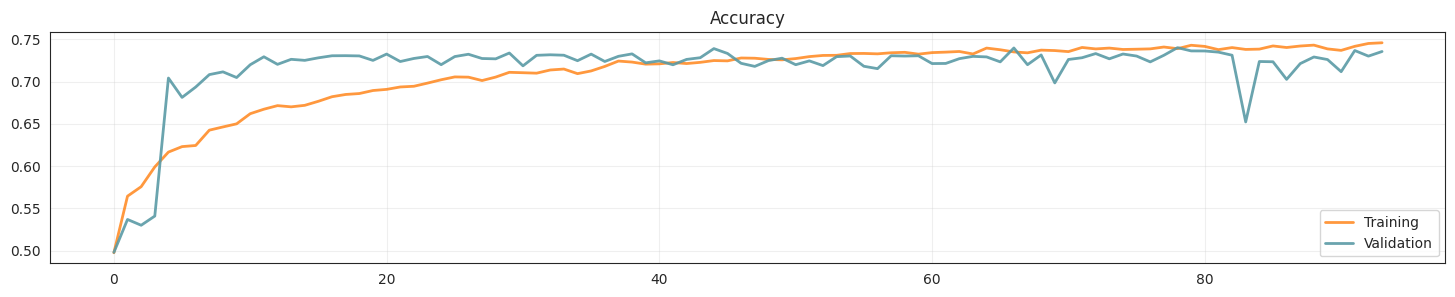

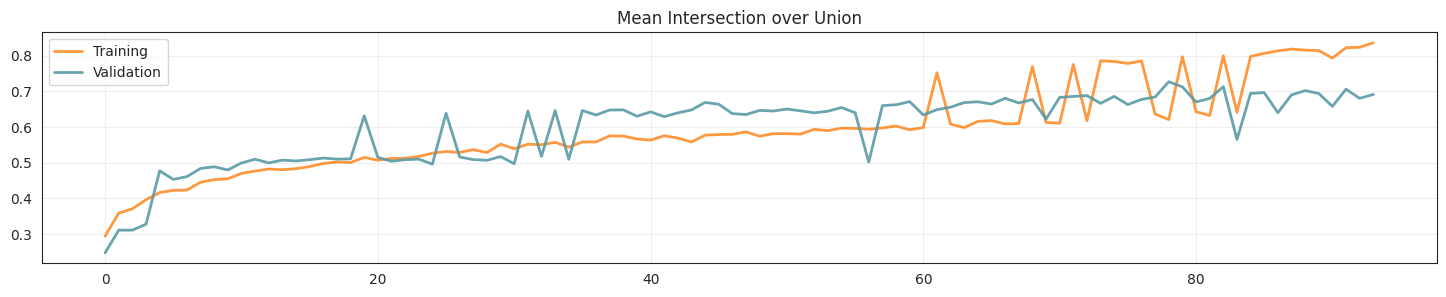

In [15]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 32, 64, 128)  │          512 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 128)  │      147,584 │ activation_2[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 128)  │          512 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_3           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1      

 Total params: 6,282,885 (23.97 MB)

 Trainable params: 6,279,301 (23.95 MB)

 Non-trainable params: 3,584 (14.00 KB)

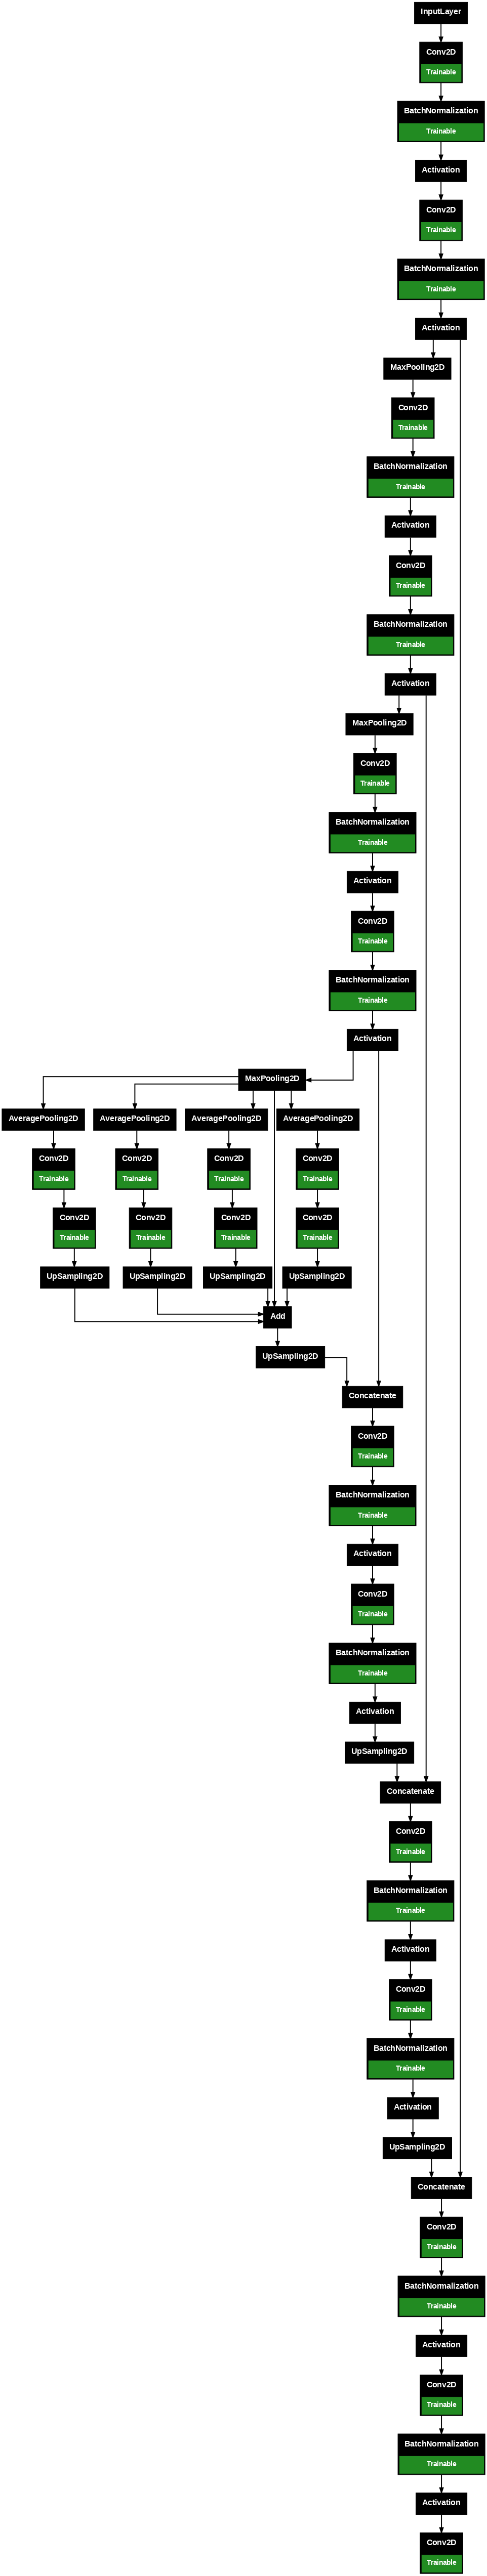

In [16]:
# Load UNet model without compiling
model_filename = 'PSPNet_72.71.keras'
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=SparseCategoricalCrossentropyWithWeights(weights), metrics=["accuracy", mean_iou])

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [17]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.6739 - loss: 0.0689 - mean_io_u: 0.6582
Test Accuracy: 0.6815
Test Mean Intersection over Union: 0.6462


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [18]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [19]:
print(model_filename)

PSPNet_72.71.keras


In [21]:
# Prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 35s 90ms/step
Predictions shape: (10022, 64, 128)


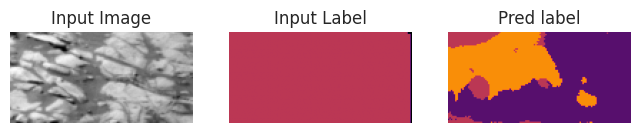

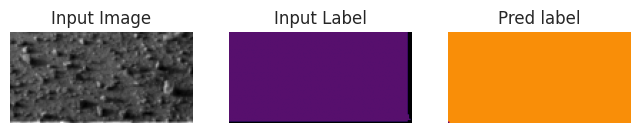

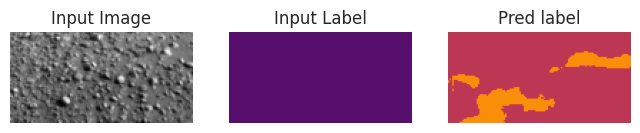

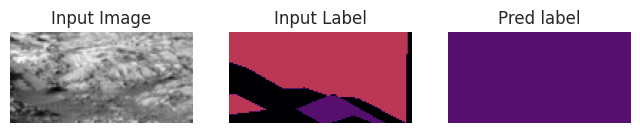

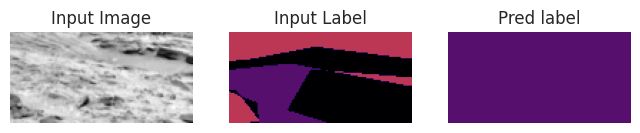

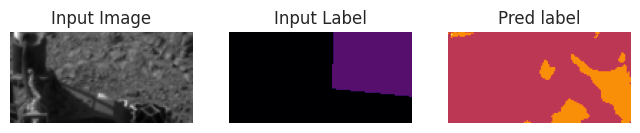

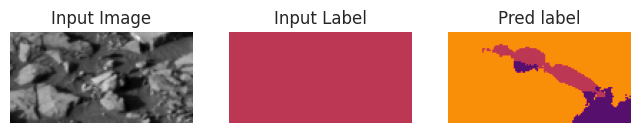

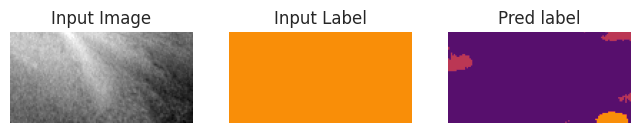

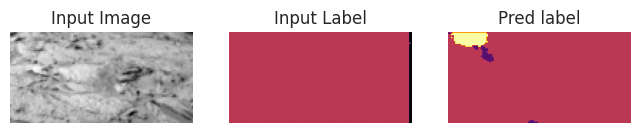

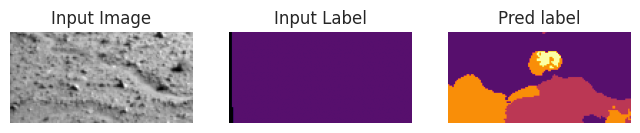

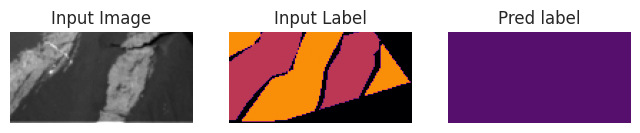

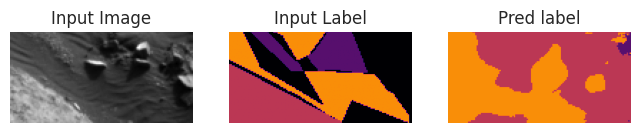

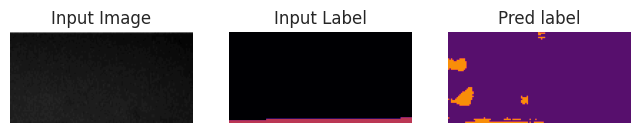

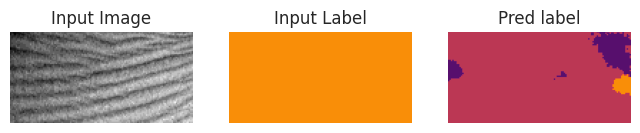

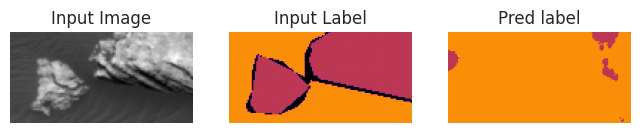

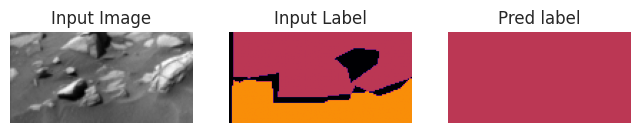

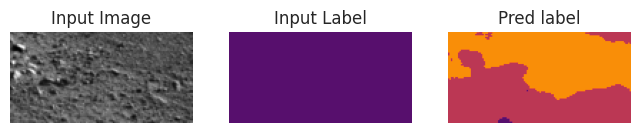

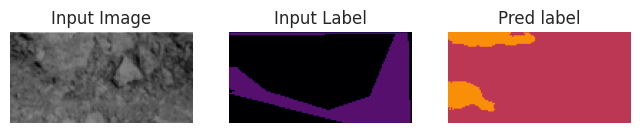

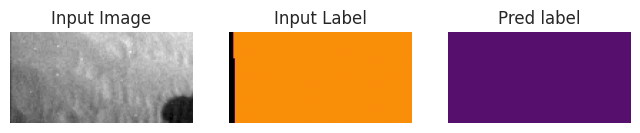

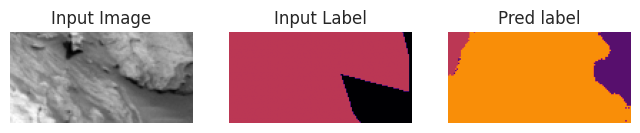

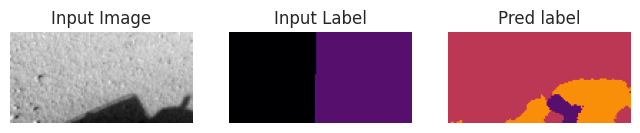

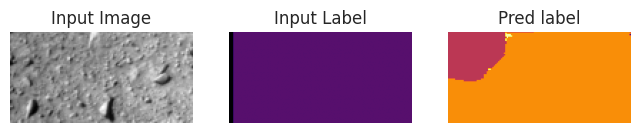

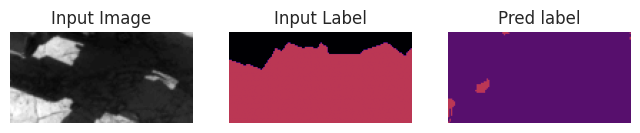

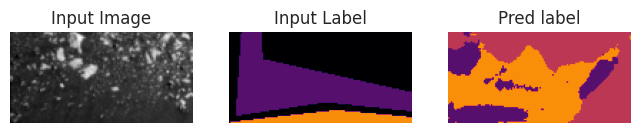

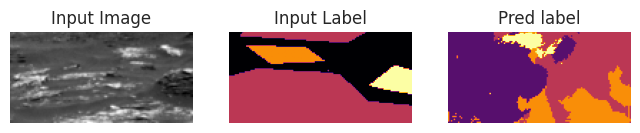

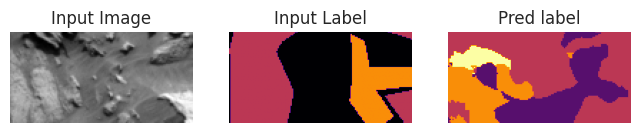

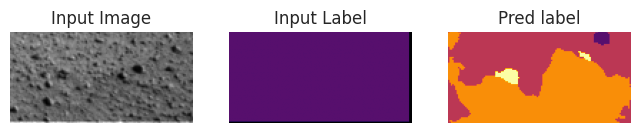

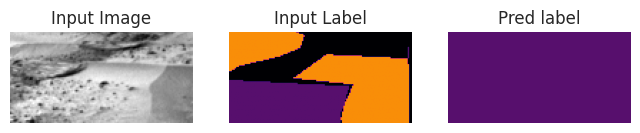

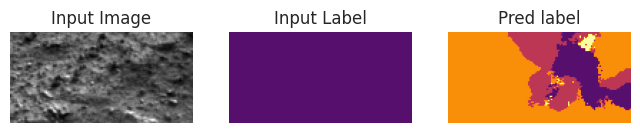

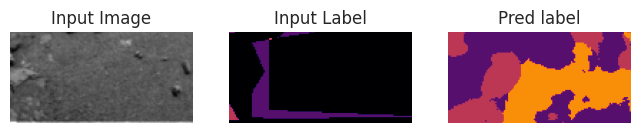

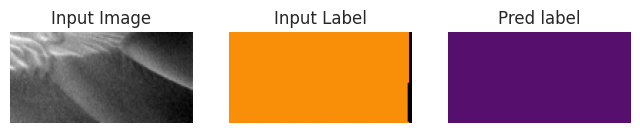

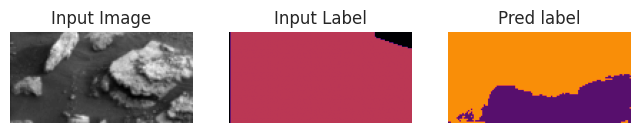

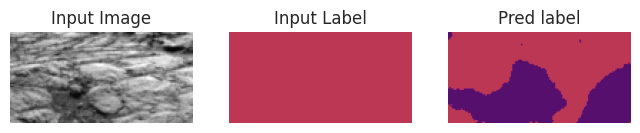

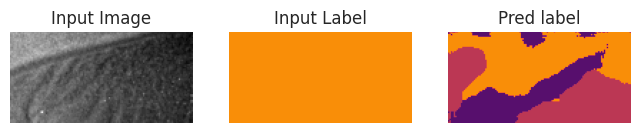

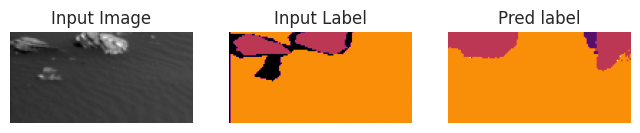

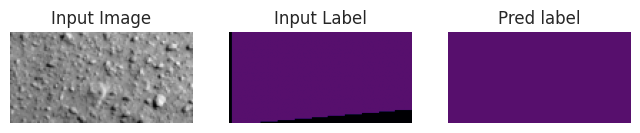

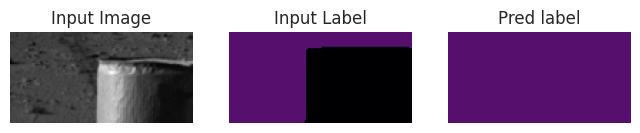

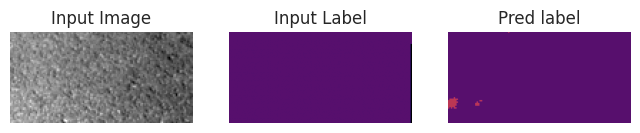

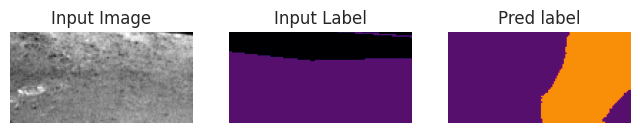

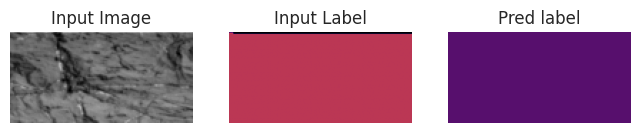

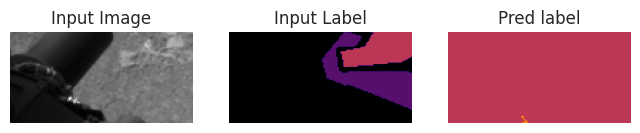

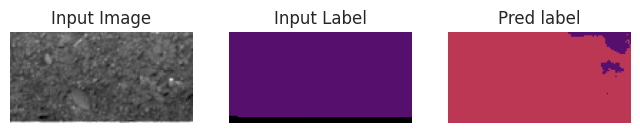

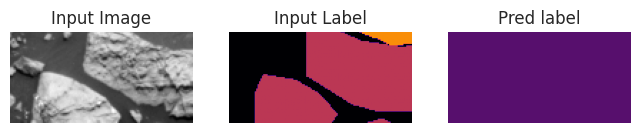

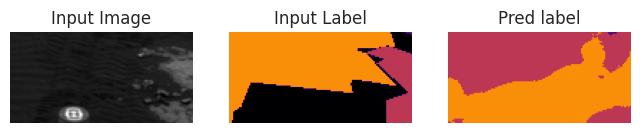

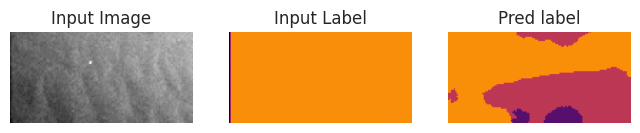

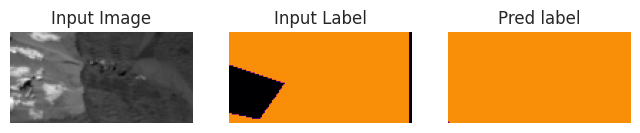

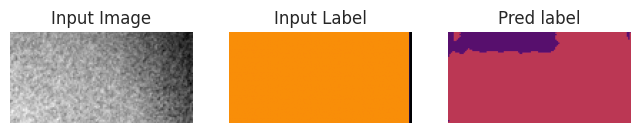

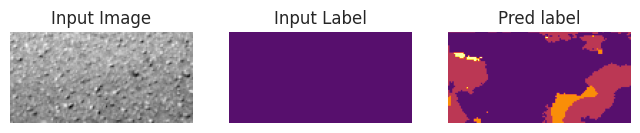

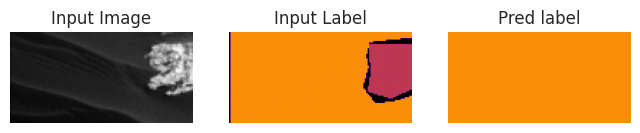

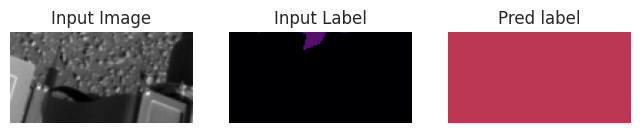

In [24]:
for index in range(50):
  plt.figure(figsize=(8,4))
  plt.subplot(1,3,1)
  plt.imshow(test_img[index], cmap='gray')
  plt.axis('off')
  plt.title("Input Image")
  plt.subplot(1,3,2)
  plt.imshow(test_lbl[index], cmap='inferno',vmin=0,vmax=4)
  plt.axis('off')
  plt.title("Input Label")
  plt.subplot(1,3,3)
  plt.imshow(preds[index], cmap='inferno',vmin=0,vmax=4)
  plt.axis('off')
  plt.title("Pred label")
  plt.show()

In [25]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [26]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>